# Genetic Programming for Symbolic Regression

This notebook implements a genetic programming algorithm to discover mathematical expressions that fit given data points. The algorithm evolves tree-based representations of mathematical formulas through selection, crossover, and mutation operations.


## Setup and Imports


In [1]:
import random
import csv
import math
import copy
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from heapq import heappush, heappop

## Constants and Configuration


In [2]:
# Supported mathematical operators
OPERATORS = ['+', '-', '*', '/']

# Mutation probability
MUTATE_PROB = 0.05

## Node Class

Represents a node in the expression tree. Each node can be either an operator or a terminal (number/variable).


In [3]:
class Node:
    """
    A node in the expression tree.

    Attributes:
        value: The value of the node (operator, number, or 'x')
        type: 'op' for operator, 'num' for terminal
        left: Left child node
        right: Right child node
        depth: Depth of this node in the tree
    """

    def __init__(self, type, depth):
        self.value = 0
        self.type = type
        self.left = None
        self.right = None
        self.depth = depth

        if type == 'op':
            self.value = OPERATORS[random.randint(0, 3)]
        elif type == 'num':
            rand = random.randint(0, 1)
            if rand == 0:
                self.value = random.randint(-5, 5)
            elif rand == 1:
                self.value = 'x'
        else:
            print('Error: type must be "op" or "num"')

    def change_to_operator(self):
        """Convert this node to an operator node."""
        self.type = 'op'
        self.value = OPERATORS[random.randint(0, 3)]
        if self.value == '/' and self.right == 0:
            self.value = OPERATORS[random.randint(0, 2)]

    def add_children(self):
        """Add left and right children to this node."""
        if self.left is None and self.right is None:
            self.change_to_operator()
            self.left = Node('num', self.depth + 1)
            self.right = Node('num', self.depth + 1)

    def display(self):
        """Display the tree structure in ASCII art."""
        lines, _, _, _ = self._display_tree()
        for line in lines:
            print(line)

    def _display_tree(self):
        """Helper method for ASCII tree visualization."""
        # Leaf node
        if self.right is None and self.left is None:
            line = '%s' % self.value
            width = len(line)
            height = 1
            middle = width // 2
            return [line], width, height, middle

        # Only left child
        if self.right is None:
            lines, n, p, x = self.left._display_tree()
            s = '%s' % self.value
            u = len(s)
            first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s
            second_line = x * ' ' + '/' + (n - x - 1 + u) * ' '
            shifted_lines = [line + u * ' ' for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, n + u // 2

        # Only right child
        if self.left is None:
            lines, n, p, x = self.right._display_tree()
            s = '%s' % self.value
            u = len(s)
            first_line = s + x * '_' + (n - x) * ' '
            second_line = (u + x) * ' ' + '\\' + (n - x - 1) * ' '
            shifted_lines = [u * ' ' + line for line in lines]
            return [first_line, second_line] + shifted_lines, n + u, p + 2, u // 2

        # Both children
        left, n, p, x = self.left._display_tree()
        right, m, q, y = self.right._display_tree()
        s = '%s' % self.value
        u = len(s)
        first_line = (x + 1) * ' ' + (n - x - 1) * '_' + s + y * '_' + (m - y) * ' '
        second_line = x * ' ' + '/' + (n - x - 1 + u + y) * ' ' + '\\' + (m - y - 1) * ' '

        if p < q:
            left += [n * ' '] * (q - p)
        elif q < p:
            right += [m * ' '] * (p - q)

        zipped_lines = zip(left, right)
        lines = [first_line, second_line] + [a + u * ' ' + b for a, b in zipped_lines]
        return lines, n + m + u, max(p, q) + 2, n + u // 2


## Tree Class

Represents a complete expression tree (individual in the population).

In [4]:
class Tree:
    """
    Expression tree representing a mathematical formula.

    Attributes:
        root: Root node of the tree
        size: Number of nodes in the tree
        depth: Maximum depth of the tree
        fitness: Mean squared error on training data
    """

    def __init__(self, size):
        self.root = Node('num', 1)
        self.size = 1
        self.depth = 1
        self.fitness = float('inf')

        # Build tree using breadth-first approach
        frontier = deque([self.root])
        while self.size < size:
            next_node = frontier.popleft()
            if next_node.left is None and next_node.right is None:
                next_node.add_children()
                self.size += 2
                frontier.append(next_node.left)
                frontier.append(next_node.right)
                if next_node.left.depth > self.depth:
                    self.depth = next_node.left.depth
            else:
                frontier.append(next_node.left)
                frontier.append(next_node.right)

    def __eq__(self, other):
        return self is other

    def __lt__(self, other):
        return self.fitness < other.fitness

    def evaluate(self, x):
        """Evaluate the expression for a given x value."""
        return self.evaluateTree(self.root, x)

    def evaluateTree(self, node, x):
        """Recursively evaluate the tree."""
        if node is None:
            return 0

        if node.value == '/' and node.right == 0:
            print("Divided by zero")
            return float('inf')

        # Leaf node
        if node.left is None and node.right is None:
            if node.value == 'x':
                return float(x)
            else:
                return node.value

        # Evaluate children
        left_sum = self.evaluateTree(node.left, x)
        right_sum = self.evaluateTree(node.right, x)

        if left_sum is None or right_sum is None:
            return None

        # Apply operator
        if node.value == '+':
            return float(left_sum + right_sum)
        elif node.value == '-':
            return float(left_sum - right_sum)
        elif node.value == '*':
            return float(left_sum * right_sum)
        else:  # Division
            if right_sum != 0:
                return float(left_sum / right_sum)
            else:
                return float('inf')

    def calcFitness(self, data):
        """Calculate fitness as mean squared error."""
        sqrerr = 0
        for row in range(len(data)):
            ans = self.evaluate(data[row][0])
            if ans is not None:
                sqrerr += (ans - data[row][1]) ** 2
        mse = sqrerr / len(data)
        self.fitness = mse
        return mse

    def crossover(self, other):
        """Perform crossover with another tree."""
        selfPath = self.getRandomBitString(random.randint(1, self.depth))
        otherPath = other.getRandomBitString(random.randint(1, other.depth))

        # Navigate to crossover point in self
        root1 = self.root
        root_depth1 = 1
        for i in range(len(selfPath)):
            if selfPath[i] == '0' and root1.left:
                parent1 = root1
                direct1 = 'l'
                root1 = root1.left
                root_depth1 += 1
            elif selfPath[i] == '1' and root1.right:
                parent1 = root1
                direct1 = 'r'
                root1 = root1.right
                root_depth1 += 1

        # Navigate to crossover point in other
        root2 = other.root
        root_depth2 = 1
        for i in range(len(otherPath)):
            if otherPath[i] == '0' and root2.left:
                parent2 = root2
                direct2 = 'l'
                root2 = root2.left
                root_depth2 += 1
            elif otherPath[i] == '1' and root2.right:
                parent2 = root2
                direct2 = 'r'
                root2 = root2.right
                root_depth2 += 1

        # Swap subtrees
        if direct1 == 'l':
            parent1.left = root2
        elif direct1 == 'r':
            parent1.right = root2

        if direct2 == 'l':
            parent2.left = root1
        elif direct2 == 'r':
            parent2.right = root1

        # Update tree properties
        other.depth = other.updateDepth(other.root)
        other.size = other.updateSize(other.root)
        return other

    def updateDepth(self, root, depth=0):
        """Recursively update tree depth."""
        if root is None:
            return depth
        depth += 1
        return max(self.updateDepth(root.right, depth),
                   self.updateDepth(root.left, depth))

    def updateSize(self, root, size=0):
        """Recursively update tree size."""
        if root is None:
            return size
        return self.updateSize(root.right, size) + self.updateSize(root.left, size) + 1

    def mutate(self, root):
        """Randomly mutate a node in the tree."""
        if random.random() < MUTATE_PROB:
            lower = max(1, self.depth - 2)
            path = self.getRandomBitString(random.randint(lower, self.depth + 2))
            direct = ''
            depth = 1

            for i in range(len(path)):
                if path[i] == '0' and root.left:
                    parent = root
                    direct = 'l'
                    root = root.left
                    depth += 1
                elif path[i] == '1' and root.right:
                    parent = root
                    direct = 'r'
                    root = root.right
                    depth += 1

            new_node = Node(root.type, depth)
            new_node.right = root.right
            new_node.left = root.left

            if direct == 'l':
                parent.left = new_node
            elif direct == 'r':
                parent.right = new_node

    def getRandomBitString(self, length):
        """Generate random binary string for tree navigation."""
        string = ''
        for i in range(length):
            bit = random.randint(0, 1)
            string += str(bit)
        return string

## Genetic Algorithm Functions

In [5]:
def new_gen(size, data):
    """Create initial population of random trees."""
    forest = []
    best_fitness = float('inf')
    best = None

    for i in range(size):
        forest.append(Tree(15))
        forest[i].calcFitness(data)
        if forest[i].fitness < best_fitness:
            best_fitness = forest[i].fitness
            best = copy.deepcopy(forest[i])

    return forest, best


def tournament(pop, num_torns, data):
    """Select best individuals from tournament groups."""
    champions = []
    torn_size = int(len(pop) / num_torns)

    for i in range(num_torns):
        best = float('inf')
        best_tree = None

        for j in range(torn_size):
            fitness = pop[(i * torn_size) + j].calcFitness(data)
            if fitness < best:
                best = fitness
                best_tree = copy.deepcopy(pop[(i * torn_size) + j])

        if best_tree is not None:
            champions.append(best_tree)
        else:
            print("No tree had a fitness better than infinity")

    # Handle remaining individuals
    if len(pop) % num_torns != 0:
        best = float('inf')
        best_tree = None

        for j in range(len(pop) % num_torns):
            fitness = pop[((num_torns - 1) * torn_size) + torn_size + j].calcFitness(data)
            if fitness < best:
                best = fitness
                best_tree = copy.deepcopy(pop[((num_torns - 1) * torn_size) + torn_size + j])

        if best_tree is not None:
            champions.append(best_tree)

    return champions


def run_generation(old_gen, num_torns, data):
    """Create new generation through selection, crossover, and mutation."""
    next_gen = []
    best_fitness = float('inf')
    best = None

    # Elitism: keep best from previous generation
    next_gen.append(old_gen[1])

    while len(next_gen) < len(old_gen[0]):
        champs = tournament(old_gen[0], num_torns, data)

        for i in range(num_torns):
            index1 = random.randint(0, len(champs) - 1)
            index2 = random.randint(0, len(champs) - 1)
            while index1 == index2:
                index2 = random.randint(0, len(champs) - 1)

            child = champs[index1].crossover(champs[index2])
            child.mutate(child.root)
            child.calcFitness(data)

            if child.fitness < best_fitness:
                best_fitness = child.fitness
                best = copy.deepcopy(child)

            next_gen.append(child)

            # 5% chance to introduce random tree for diversity
            if random.randint(0, 100) < 5:
                next_gen.append(Tree(10))

    return next_gen, best


def evolution(data, gen_size, num_torns, tol):
    """
    Main evolution loop.

    Args:
        data: Training data [(x, y), ...]
        gen_size: Population size
        num_torns: Number of tournament groups
        tol: Fitness tolerance for early stopping

    Returns:
        List of best fitness values per generation
    """
    bests = []
    converged = False

    # Create initial population
    original = new_gen(gen_size, data)
    heappush(bests, original[1])
    old_gen = original

    converg_count = 0
    gen_count = 0
    fitness_history = []

    while not converged:
        # Check tolerance
        if bests[0].fitness < tol:
            converged = True
            print(f"✓ Error below tolerance! Best tree:")
            bests[0].root.display()
            print(f"Converged after {gen_count} generations")
            break

        gen_count += 1
        print(f'\n=== Generation {gen_count} ===')

        # Create new generation
        next_gen = run_generation(old_gen, num_torns, data)
        best = next_gen[1]

        print(f'Best fitness this generation: {best.fitness:.6f}')

        try:
            heappush(bests, best)
        except:
            print('Tie break error')
            continue

        old_gen = next_gen

        print(f"Best fitness overall: {bests[0].fitness:.6f}")
        print("Current best tree:")
        bests[0].root.display()

        fitness_history.append(best.fitness)

        # Check for convergence
        if best.fitness >= bests[0].fitness:
            converg_count += 1
            if converg_count > 60:
                print(f'\n⚠ No improvement in {converg_count} generations. Stopping.')
                converged = True
        else:
            converg_count = 0

    return fitness_history


def plot(fitness_history, runtime):
    """Plot fitness evolution over generations."""
    print(f'\n⏱ Runtime: {int(runtime)} seconds')

    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history, linewidth=2, color='#2E86AB')
    plt.ylabel('Fitness (MSE)', fontsize=12)
    plt.xlabel('Generation', fontsize=12)
    plt.title('Fitness Evolution Over Generations', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Experiment 1: Quadratic Function

Target function: $f(x) = x^2 + 3x - 2$

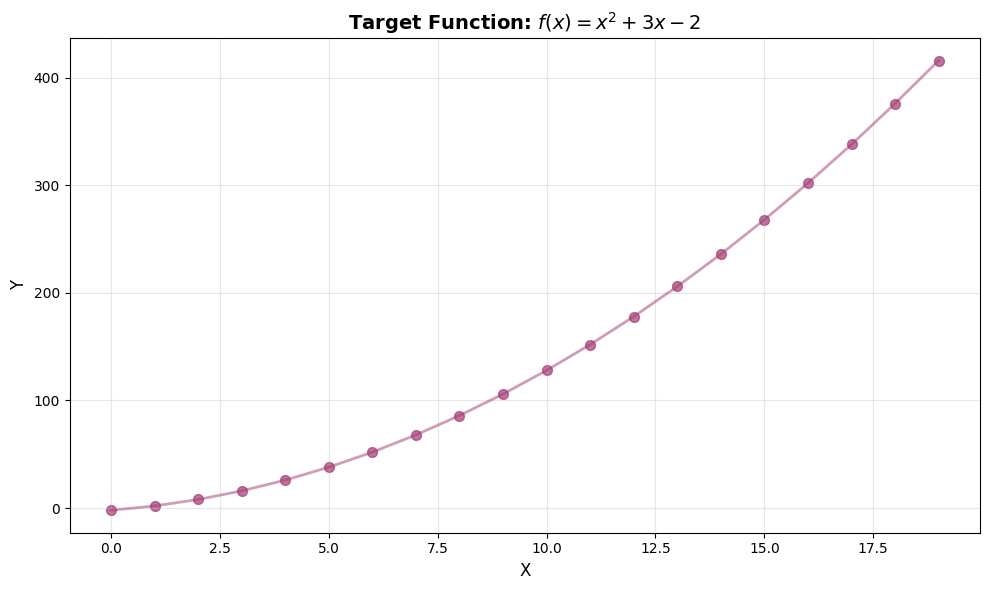

In [7]:
# Generate data
first_col = np.arange(20)

def func(x):
    return x**2 + 3*x - 2

second_col = func(first_col)
matrix = np.column_stack((first_col, second_col))

# Visualize target function
plt.figure(figsize=(10, 6))
plt.scatter(matrix[:, 0], matrix[:, 1], color='#A23B72', s=50, alpha=0.7)
plt.plot(matrix[:, 0], matrix[:, 1], color='#A23B72', linewidth=2, alpha=0.5)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Target Function: $f(x) = x^2 + 3x - 2$', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Run evolution
gen_size = 100
data = matrix
start_time = time.time()
p = evolution(data, gen_size, int(math.sqrt(gen_size)), 0.1)
time1 = time.time() - start_time


=== Generation 1 ===
Best fitness this generation: 121.555556
Best fitness overall: 121.555556
Current best tree:
    ___+___      
   /       \     
  _-_     _-___  
 /   \   /     \ 
 *   /   -    _* 
/ \ / \ / \  /  \
x x x 3 2 x  -  x
            / \  
            0 5  

=== Generation 2 ===
Best fitness this generation: 4.000000
Best fitness overall: 4.000000
Current best tree:
    ___*_______  
   /           \ 
  _-_       ___+ 
 /   \     /    \
 +   -    _-_   x
/ \ / \  /   \   
x x x 3  -   -   
        / \ / \  
        0 x 0 x  

=== Generation 3 ===
Best fitness this generation: 4.000000
Best fitness overall: 4.000000
Current best tree:
    ___*_______  
   /           \ 
  _-_       ___+ 
 /   \     /    \
 +   -    _-_   x
/ \ / \  /   \   
x x x 3  -   -   
        / \ / \  
        0 x 0 x  

=== Generation 4 ===
Best fitness this generation: 4.000000
Best fitness overall: 4.000000
Current best tree:
    ___*_______  
   /           \ 
  _-_       ___+ 
 /   \     /


⏱ Runtime: 68 seconds


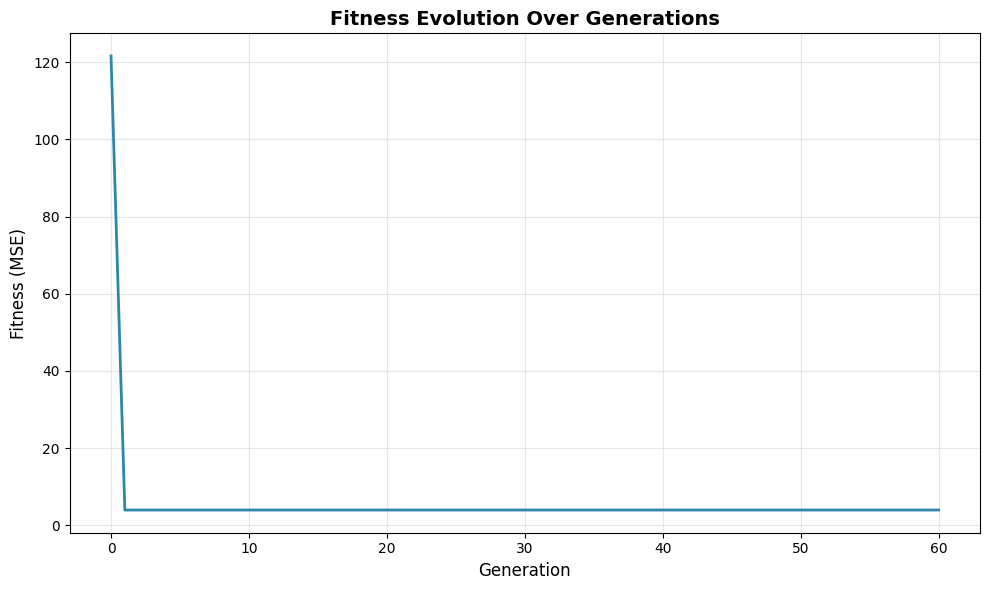

In [9]:
plot(p, time1)

## Experiment 2: Logarithmic Function

Target function: $f(x) = \ln(x) + 4x - 2$

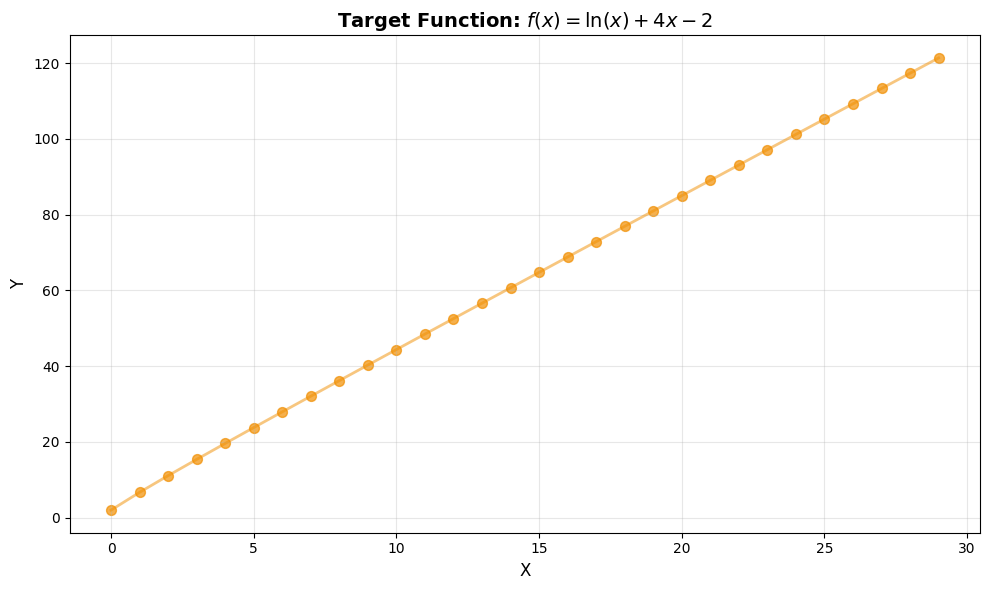

In [10]:
# Generate data
first_col = np.arange(30)

def func(x):
    return np.log(x) + 4*x - 2

second_col = func(first_col + 1)
matrix2 = np.column_stack((first_col, second_col))

# Visualize target function
plt.figure(figsize=(10, 6))
plt.scatter(matrix2[:, 0], matrix2[:, 1], color='#F18F01', s=50, alpha=0.7)
plt.plot(matrix2[:, 0], matrix2[:, 1], color='#F18F01', linewidth=2, alpha=0.5)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Target Function: $f(x) = \\ln(x) + 4x - 2$', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Run evolution
gen_size = 100
data = matrix2
start_time = time.time()
p = evolution(data, gen_size, int(math.sqrt(gen_size)), 0.9)
time2 = time.time() - start_time


=== Generation 1 ===
Best fitness this generation: 42.801166
Best fitness overall: 42.801166
Current best tree:
     ___-____    
    /        \   
  __-_      _-_  
 /    \    /   \ 
 +_   -    *   + 
/  \ / \  / \ / \
x -4 2 x -2 x 1 3

=== Generation 2 ===
Best fitness this generation: 6.892303
Best fitness overall: 6.892303
Current best tree:
     ____-____    
    /         \   
  __-__      _-_  
 /     \    /   \ 
 +_    -    *   + 
/  \  / \  / \ / \
x -4 -2 x -2 x 1 3

=== Generation 3 ===
Best fitness this generation: 0.937871
Best fitness overall: 0.937871
Current best tree:
     ____-____    
    /         \   
  __-__      _-_  
 /     \    /   \ 
 +_    -    *   + 
/  \  / \  / \ / \
x -4 -4 x -2 x 1 3

=== Generation 4 ===
Best fitness this generation: 0.937871
Best fitness overall: 0.937871
Current best tree:
     ____-____    
    /         \   
  __-__      _-_  
 /     \    /   \ 
 +_    -    *   + 
/  \  / \  / \ / \
x -4 -4 x -2 x 1 3

=== Generation 5 ===
Best fi


⏱ Runtime: 68 seconds


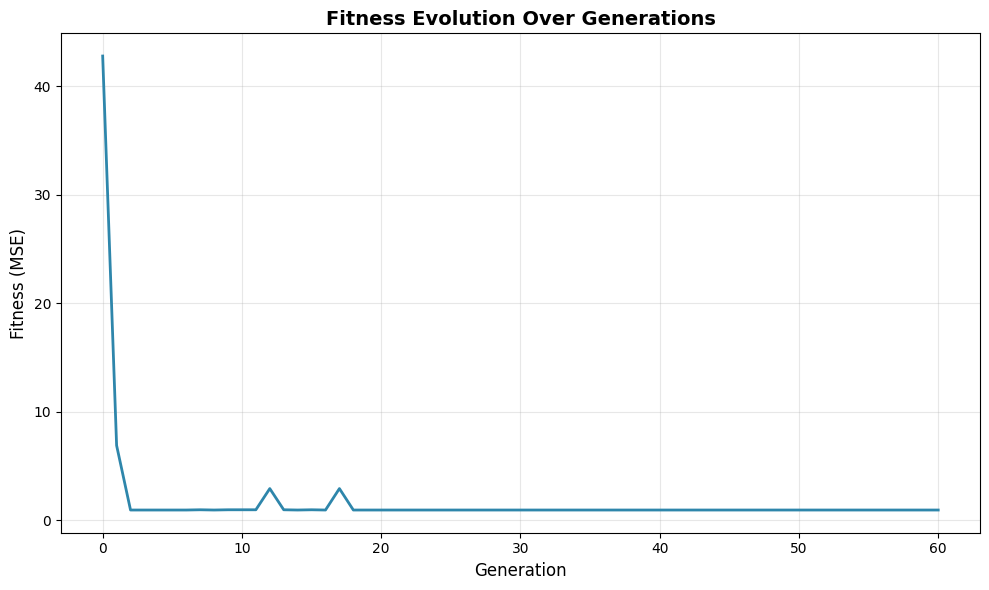

In [12]:
plot(p, time2)

## Experiment 3: Piecewise Function

Target function:
$$
f(x) = \begin{cases}
x^2 & \text{if } x < 10 \\
x + 100 & \text{if } x \geq 10
\end{cases}
$$

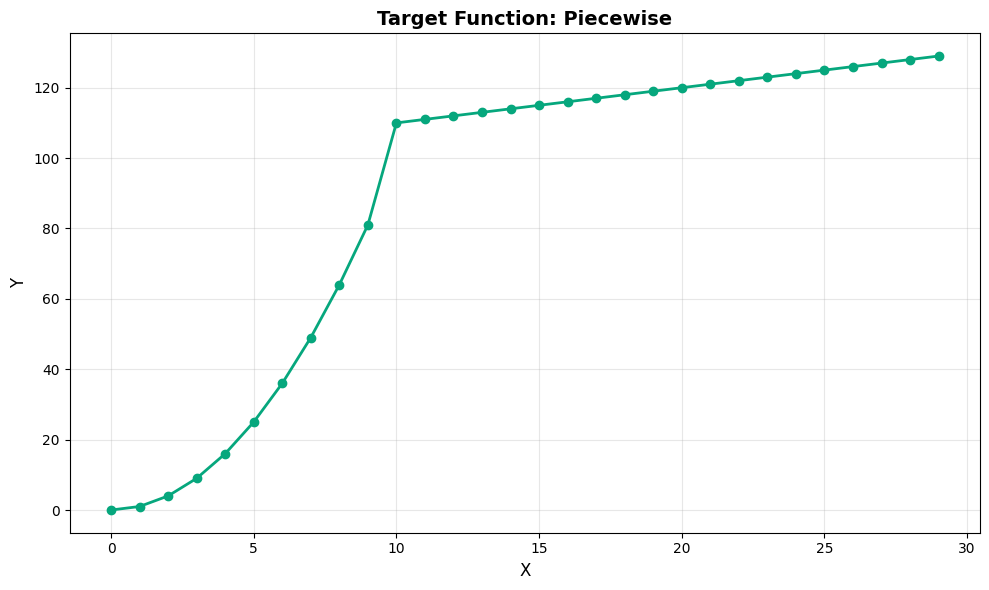

In [13]:
# Generate data
first_col = np.arange(30)

def func(x):
    y = []
    for i in x:
        if i < 10:
            y.append(i**2)
        else:
            y.append(i + 100)
    return y

second_col = func(first_col)
matrix4 = np.column_stack((first_col, second_col))

# Visualize target function
plt.figure(figsize=(10, 6))
plt.plot(matrix4[:, 0], matrix4[:, 1], color='#06A77D', linewidth=2, marker='o', markersize=6)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Target Function: Piecewise', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Run evolution
gen_size = 20
data = matrix4
start_time = time.time()
p3 = evolution(data, gen_size, int(math.sqrt(gen_size)), 2)
time3 = time.time() - start_time


=== Generation 1 ===
No tree had a fitness better than infinity
No tree had a fitness better than infinity
No tree had a fitness better than infinity
No tree had a fitness better than infinity
No tree had a fitness better than infinity
Best fitness this generation: 2092.331238
Best fitness overall: 1453.687963
Current best tree:
    ___+___    
   /       \   
  _/_     _+_  
 /   \   /   \ 
 *   +   -   * 
/ \ / \ / \ / \
x 5 2 4 3 x 4 x

=== Generation 2 ===
Best fitness this generation: 1184.100000
Best fitness overall: 1184.100000
Current best tree:
    ___+___    
   /       \   
  _-_     _+_  
 /   \   /   \ 
 +   -   -   * 
/ \ / \ / \ / \
5 0 3 x 3 x 4 x

=== Generation 3 ===
Best fitness this generation: 718.600000
Best fitness overall: 718.600000
Current best tree:
    ___+___    
   /       \   
  _-_     _+_  
 /   \   /   \ 
 +   -   -   * 
/ \ / \ / \ / \
5 0 3 x 3 4 4 x

=== Generation 4 ===
Best fitness this generation: 586.933333
Best fitness overall: 586.933333
Curr


⏱ Runtime: 90 seconds


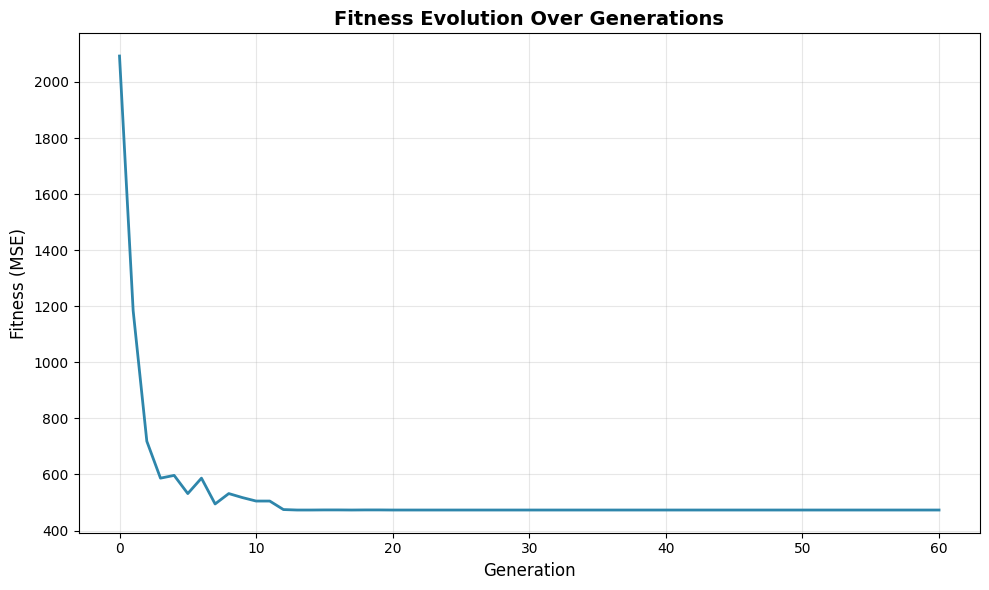

In [15]:
plot(p3, time3)

## Experiment 4: External Dataset

Load and process an external CSV file.

In [ ]:
def readData(filename):
    """Read CSV data file."""
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        dataset = list(csv_reader)
        columns = dataset[0]
        dataset = dataset[1:]

        for row in range(len(dataset)):
            for col in range(len(dataset[row])):
                dataset[row][col] = float(dataset[row][col])

        return dataset

In [16]:
data = readData('dataset.csv')
gen_size = 10
start = time.time()
p4 = evolution(data[:500], gen_size, int(math.sqrt(gen_size)), 1)
time4 = time.time() - start


=== Generation 1 ===
Best fitness this generation: 348.096197
Best fitness overall: 302.125474
Current best tree:
    ___+___    
   /       \   
  _+_     _*_  
 /   \   /   \ 
 -   *   /   + 
/ \ / \ / \ / \
0 x x x 2 x x x

=== Generation 2 ===
Best fitness this generation: 246.319087
Best fitness overall: 246.319087
Current best tree:
    ___+_        
   /     \       
  _+_    *___    
 /   \  /    \   
 -   *  5   _*_  
/ \ / \    /   \ 
0 x x x    /   + 
          / \ / \
          2 x x x

=== Generation 3 ===
Best fitness this generation: 369.589172
Best fitness overall: 246.319087
Current best tree:
    ___+_        
   /     \       
  _+_    *___    
 /   \  /    \   
 -   *  5   _*_  
/ \ / \    /   \ 
0 x x x    /   + 
          / \ / \
          2 x x x

=== Generation 4 ===
Best fitness this generation: 369.589172
Best fitness overall: 246.319087
Current best tree:
    ___+_        
   /     \       
  _+_    *___    
 /   \  /    \   
 -   *  5   _*_  
/ \ / \    /  


⏱ Runtime: 9 seconds


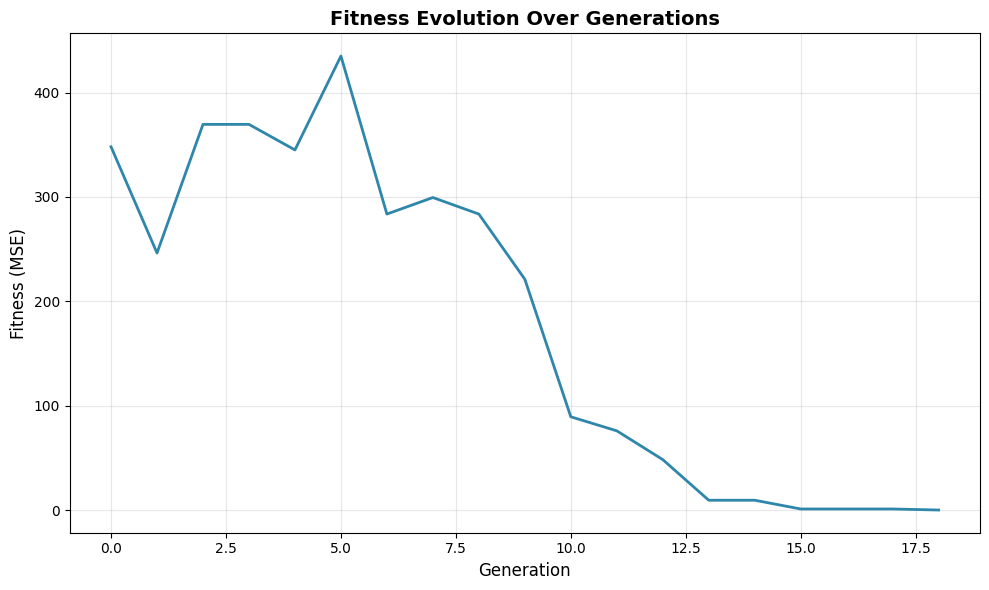

In [17]:
plot(p4, time4)